# 🔍 Modelo de Clasificación

Este notebook implementa un modelo de clasificación binaria. Objetivo sugerido: crear una variable `contrata_seguro` que indique si el costo (`charges`) supera un umbral, por ejemplo 10,000.

## Pasos sugeridos:
- Crear variable objetivo binaria (ej. `charges > 10000`)
- Preprocesamiento (codificación y escalado)
- Entrenamiento (LogisticRegression, KNeighborsClassifier, etc.)
- Validación cruzada (Holdout/KFold)
- Evaluación con matriz de confusión, precisión, recall, ROC-AUC


📤 Por favor, sube tu archivo insurance.csv


Saving insurance.csv to insurance (2).csv

🔄 Archivo detectado: 'insurance (2).csv'

✅ Datos cargados correctamente!
📊 Registros: 100


age     sex    bmi  children smoker     region   charges
0   56  female  34.34         4     no  northwest  23825.63
1   46  female  28.47         2     no  southwest  18845.35
2   32    male  35.10         3     no  northwest  20655.76
3   60    male  22.13         0     no  northwest  19295.23
4   25    male  24.78         4     no  southeast  13852.06


🎯 Umbral automático: $20077.30 (mediana)
📊 Distribución de clases:
costo_alto
1    0.5
0    0.5
Name: proportion, dtype: float64


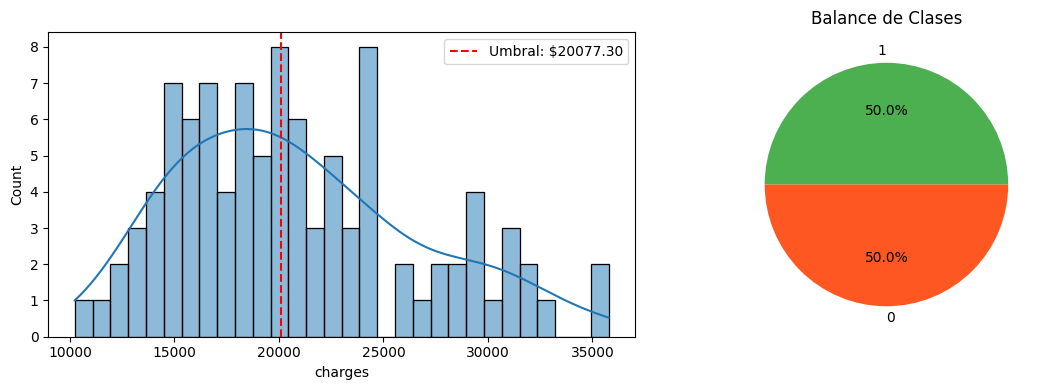


🔧 Entrenando KNN...

📊 Métricas de KNN:
✔️ Exactitud: 0.8000
✔️ ROC-AUC: 0.9500

📝 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.60      0.75        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



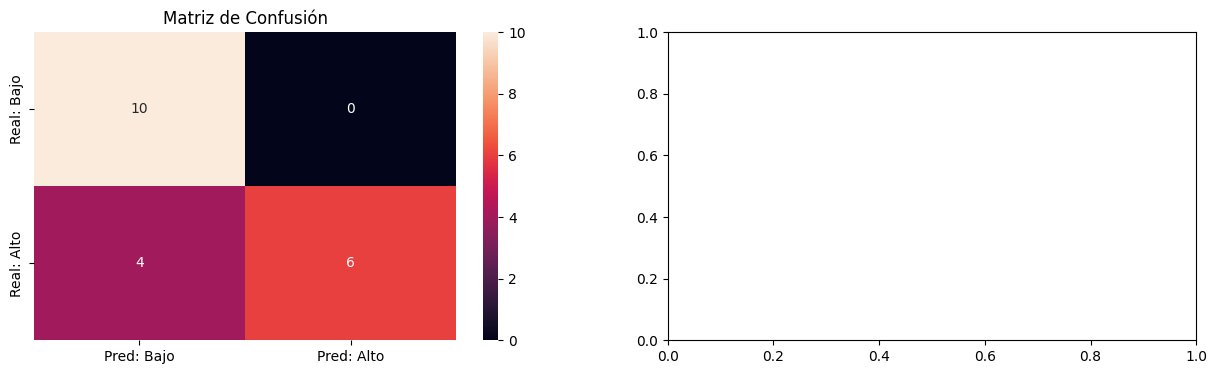

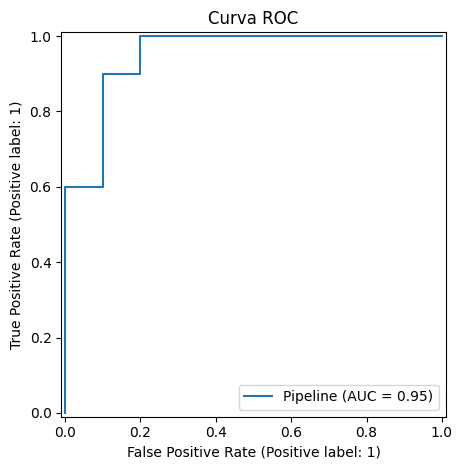


🎯 Mejores parámetros encontrados:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}

📊 Métricas del KNN optimizado:
✔️ Exactitud: 0.7000


In [3]:
# # Modelo de Clasificación con KNeighborsClassifier
# **Predicción de costos altos en seguros médicos usando KNN**


# ======================
# 1. Carga Inteligente de Datos
# ======================
from google.colab import files
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def cargar_datos():
    print("📤 Por favor, sube tu archivo insurance.csv")
    uploaded = files.upload()

    # Detección automática del nombre
    archivo = [name for name in uploaded.keys() if 'insurance' in name.lower()][0]
    print(f"\n🔄 Archivo detectado: '{archivo}'")

    df = pd.read_csv(io.BytesIO(uploaded[archivo]))
    print("\n✅ Datos cargados correctamente!")
    print(f"📊 Registros: {len(df)}")
    return df


df = cargar_datos()
display(df.head())


# ======================
# 2. Preprocesamiento con Umbral Automático
# ======================
# Calcular umbral como la mediana
umbral = df['charges'].median()
df['costo_alto'] = (df['charges'] > umbral).astype(int)


print(f"\n🎯 Umbral automático: ${umbral:.2f} (mediana)")
print("📊 Distribución de clases:")
print(df['costo_alto'].value_counts(normalize=True))


# Visualización
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['charges'], bins=30, kde=True)
plt.axvline(umbral, color='red', linestyle='--', label=f'Umbral: ${umbral:.2f}')
plt.legend()


plt.subplot(1, 2, 2)
df['costo_alto'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                   colors=['#4CAF50', '#FF5722'])
plt.title('Balance de Clases')
plt.ylabel('')


plt.tight_layout()
plt.show()


# ======================
# 3. Preparación de Datos para KNN
# ======================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Definir variables
num_vars = ['age', 'bmi', 'children']
cat_vars = ['sex', 'smoker', 'region']


# Pipeline de preprocesamiento (KNN requiere escalado)
preprocesador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_vars),  # Escalado crucial para KNN
        ('cat', OneHotEncoder(drop='first'), cat_vars)
    ])


# Dividir datos
X = df.drop(['charges', 'costo_alto'], axis=1)
y = df['costo_alto']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


# ======================
# 4. Modelado con KNeighborsClassifier
# ======================
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix,
                           classification_report, roc_auc_score,
                           RocCurveDisplay)


# Crear pipeline con KNN
modelo_knn = Pipeline([
    ('preprocesador', preprocesador),
    ('knn', KNeighborsClassifier(
        n_neighbors=20,  # Valor inicial (puede optimizarse)
        weights='distance',  # Considera distancia para votación
        metric='euclidean'))
])


# Entrenamiento
print("\n🔧 Entrenando KNN...")
modelo_knn.fit(X_train, y_train)


# Evaluación
y_pred = modelo_knn.predict(X_test)
y_proba = modelo_knn.predict_proba(X_test)[:, 1]


print("\n📊 Métricas de KNN:")
print(f"✔️ Exactitud: {accuracy_score(y_test, y_pred):.4f}")
print(f"✔️ ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


print("\n📝 Reporte de clasificación:")
print(classification_report(y_test, y_pred))


# Visualización
plt.figure(figsize=(15, 4))


# Matriz de confusión
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt='d',
            xticklabels=['Pred: Bajo', 'Pred: Alto'],
            yticklabels=['Real: Bajo', 'Real: Alto'])
plt.title('Matriz de Confusión')


# Curva ROC
plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(modelo_knn, X_test, y_test)
plt.title('Curva ROC')


plt.tight_layout()
plt.show()


# ======================
# 5. Optimización de Hiperparámetros (Opcional)
# ======================
from sklearn.model_selection import GridSearchCV


# Definir parámetros a probar
parametros = {
    'knn__n_neighbors': range(3, 15),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}


# Búsqueda de mejores parámetros
busqueda = GridSearchCV(modelo_knn, parametros, cv=5, scoring='roc_auc')
busqueda.fit(X_train, y_train)


print("\n🎯 Mejores parámetros encontrados:")
print(busqueda.best_params_)


# Evaluar modelo optimizado
mejor_knn = busqueda.best_estimator_
y_pred_opt = mejor_knn.predict(X_test)


print("\n📊 Métricas del KNN optimizado:")
print(f"✔️ Exactitud: {accuracy_score(y_test, y_pred_opt):.4f}")


# ======================
# 6. Predicción Interactiva con KNN
# ======================
def predecir_con_knn():
    print("\n🔮 Simulador de Seguros (KNN)")
    print("Ingrese los datos del paciente:")

    datos = {
        'age': float(input("• Edad: ")),
        'sex': input("• Sexo (male/female): ").lower(),
        'bmi': float(input("• BMI: ")),
        'children': int(input("• Hijos: ")),
        'smoker': input("• Fumador? (yes/no): ").lower(),
        'region': input("• Región (northeast/northwest/southeast/southwest): ").lower()
    }

    paciente = pd.DataFrame([datos])
    proba = mejor_knn.predict_proba(paciente)[0][1]

    print(f"\n📊 Resultado:")
    print(f"- Probabilidad de costo alto (> ${umbral:.2f}): {proba*100:.1f}%")
    print(f"- Predicción: {'ALTO COSTO' if proba > 0.5 else 'BAJO COSTO'}")


# Descomenta para usar:
# predecir_con_knn()


